# 04 – Legal Contract Clause Classification

## Team Members
- Khaja Moinuddin Mohammed
- Venkat Saketh Kommi
- Sowmya Polagoni

**Run order:** Fourth (after 00, 02_eda, 03_data_preprocessing). Loads from `data/processed/` and trains both models.

## Project Overview
Classifying legal contract clauses using Feedforward and LSTM Neural Models


## 1. Import Necessary Libraries


In [1]:
import pandas as pd
import numpy as np
import json
import os
from pathlib import Path

import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Project root: directory containing Notebooks/ and scripts/
project_root = Path.cwd() if (Path.cwd() / "scripts").exists() else Path.cwd().parent
os.makedirs(project_root / "Visualizations", exist_ok=True)
os.makedirs(project_root / "Models", exist_ok=True)

np.random.seed(42)
tf.random.set_seed(42)


## 2. Load prepared data

Preprocessing (cleaning, encoding, TF-IDF, tokenization, train/test split) is done in **`03_data_preprocessing.ipynb`**. That notebook saves a clean dataset and model-ready arrays under `data/processed/`. Here we load them so we can train and evaluate models.


In [ ]:
# Path to prepared data (run 03_data_preprocessing.ipynb first)
processed_dir = project_root / "data" / "processed"

if not processed_dir.exists():
    raise FileNotFoundError(
        f"Prepared data not found at {processed_dir}. "
        "Run 03_data_preprocessing.ipynb first to create data/processed/."
    )

import joblib

# Arrays
X_train_tfidf_dense = np.load(processed_dir / "X_train_tfidf_dense.npy")
X_test_tfidf_dense = np.load(processed_dir / "X_test_tfidf_dense.npy")
X_train_padded = np.load(processed_dir / "X_train_padded.npy")
X_test_padded = np.load(processed_dir / "X_test_padded.npy")
y_train = np.load(processed_dir / "y_train.npy")
y_test = np.load(processed_dir / "y_test.npy")

# Sklearn objects
label_encoder = joblib.load(processed_dir / "label_encoder.joblib")
tfidf_vectorizer = joblib.load(processed_dir / "tfidf_vectorizer.joblib")

# Keras Tokenizer
import pickle
with open(processed_dir / "tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Config
with open(processed_dir / "config.json") as f:
    config = json.load(f)
num_classes = config["num_classes"]
max_sequence_length = config["max_sequence_length"]
actual_vocab_size = config["vocab_size"]
reverse_label_mapping = {int(k): v for k, v in config["reverse_label_mapping"].items()}
class_weights = {int(k): v for k, v in config["class_weights"].items()}

print(f"Loaded from {processed_dir}")
print(f"  X_train_tfidf_dense: {X_train_tfidf_dense.shape}")
print(f"  X_test_tfidf_dense: {X_test_tfidf_dense.shape}")
print(f"  X_train_padded: {X_train_padded.shape}")
print(f"  X_test_padded: {X_test_padded.shape}")
print(f"  y_train: {y_train.shape}, y_test: {y_test.shape}")
print(f"  num_classes: {num_classes}")


## 3. Model Creation and Training

Create and train both models:
1. Feedforward Neural Network (MLP) with TF-IDF features
2. LSTM-Based Text Classifier with sequence embeddings


### 3.1 Model 1: Feedforward Neural Network (MLP) with TF-IDF


In [39]:
print("MODEL 1: FEEDFORWARD NEURAL NETWORK (MLP) WITH TF-IDF")

input_dim = X_train_tfidf_dense.shape[1]
hidden_units_1 = 512
hidden_units_2 = 256
dropout_rate = 0.3

print(f"\nModel Architecture:")
print(f"  Input Layer: {input_dim} features (TF-IDF)")
print(f"  Hidden Layer 1: {hidden_units_1} units, ReLU activation")
print(f"  Dropout: {dropout_rate}")
print(f"  Hidden Layer 2: {hidden_units_2} units, ReLU activation")
print(f"  Dropout: {dropout_rate}")
print(f"  Output Layer: {num_classes} units, Softmax activation")
print(f"  Total Parameters: ~{(input_dim * hidden_units_1 + hidden_units_1 * hidden_units_2 + hidden_units_2 * num_classes):,}")

model_ff = Sequential([
    Dense(hidden_units_1, activation='relu', input_dim=input_dim, name='hidden_1'),
    Dropout(dropout_rate, name='dropout_1'),
    Dense(hidden_units_2, activation='relu', name='hidden_2'),
    Dropout(dropout_rate, name='dropout_2'),
    Dense(num_classes, activation='softmax', name='output')
])

model_ff.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nModel compiled successfully!")
print(f"\nModel Summary:")
model_ff.summary()


MODEL 1: FEEDFORWARD NEURAL NETWORK (MLP) WITH TF-IDF

Model Architecture:
  Input Layer: 5000 features (TF-IDF)
  Hidden Layer 1: 512 units, ReLU activation
  Dropout: 0.3
  Hidden Layer 2: 256 units, ReLU activation
  Dropout: 0.3
  Output Layer: 10 units, Softmax activation
  Total Parameters: ~2,693,632

Model compiled successfully!

Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,694,410 (10.28 MB)

 Trainable params: 2,694,410 (10.28 MB)

 Non-trainable params: 0 (0.00 B)

### 3.1.3 Notes

Optional: try reducing dropout or hidden layer size for experiments.


#### 3.1.1 Train Feedforward Model


In [40]:
print("TRAINING FEEDFORWARD NEURAL NETWORK")

batch_size = 64
epochs = 50
validation_split = 0.1

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    str(project_root / "Models" / "best_model_ff.h5"),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

print(f"\nTraining Configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Max epochs: {epochs}")
print(f"  Validation split: {validation_split}")
print(f"  Early stopping: Patience = 5")
print(f"  Class weights: Using balanced weights")

print(f"\nStarting training...")
history_ff = model_ff.fit(
    X_train_tfidf_dense, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

print(f"\nTraining completed!")
print(f"  Best epoch: {len(history_ff.history['loss'])}")
print(f"  Best validation loss: {min(history_ff.history['val_loss']):.4f}")
print(f"  Best validation accuracy: {max(history_ff.history['val_accuracy']):.4f}")


TRAINING FEEDFORWARD NEURAL NETWORK

Training Configuration:
  Batch size: 64
  Max epochs: 50
  Validation split: 0.1
  Early stopping: Patience = 5
  Class weights: Using balanced weights

Starting training...
Epoch 1/50
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5532 - loss: 1.5510
Epoch 1: val_loss improved from None to 0.60829, saving model to Models/best_model_ff.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7025 - loss: 0.9003 - val_accuracy: 0.8217 - val_loss: 0.6083
Epoch 2/50
150/156 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8660 - loss: 0.2142
Epoch 2: val_loss improved from 0.60829 to 0.51557, saving model to Models/best_model_ff.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8905 - loss: 0.1649 - val_accuracy: 0.8661 - val_loss: 0.5156
Epoch 3/50
151/156 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9243 - loss: 0.0963
Epoch 3: val_loss did not improve from 0.51557
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9330 - loss: 0.0869 - val_accuracy: 0.8534 - val_loss: 0.5630
Epoch 4/50
153/156 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9424 - loss: 0.0650
Epoch 4: val_loss did not improve from 0.51557
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9468 - loss: 0.0610 - val_accuracy: 0.8652 - val_loss: 0.5673
Epoch 5/50
153/156 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9576 - loss: 0.0476
Epoch 5: val_loss did not improve from 0.51557
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9625 - loss: 0.0447 - val_accuracy: 0.8742 - val_loss: 0.5812
Epoch 6/50
154/156 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9684 - loss: 0.0368
Epoch 6: val_loss did not improve from 0.51557


#### 3.1.2 Evaluate Feedforward Model

We evaluate the Feedforward model's performance by calculating overall metrics and per-class accuracy/precision for each legal clause category. This helps us understand which categories the model predicts most accurately and identify areas for improvement.


EVALUATING FEEDFORWARD NEURAL NETWORK

Test Set Performance:
  Loss: 0.2679
  Accuracy: 0.9217 (92.17%)

Classification Report:
                  precision    recall  f1-score   support

  Agreement Date       0.86      1.00      0.93        87
 Anti-Assignment       0.88      0.98      0.93       128
    Audit Rights       0.96      1.00      0.98       102
Cap On Liability       0.89      0.96      0.92       106
 Expiration Date       0.70      0.97      0.82        73
   Governing Law       0.97      0.99      0.98        90
       Insurance       0.95      0.99      0.97       116
   License Grant       0.61      0.95      0.74       107
           Other       0.99      0.85      0.91       998
         Parties       0.98      0.99      0.98       365

        accuracy                           0.92      2172
       macro avg       0.88      0.97      0.92      2172
    weighted avg       0.94      0.92      0.92      2172


Overall Metrics:
  Precision (weighted): 0.9381
  Recall

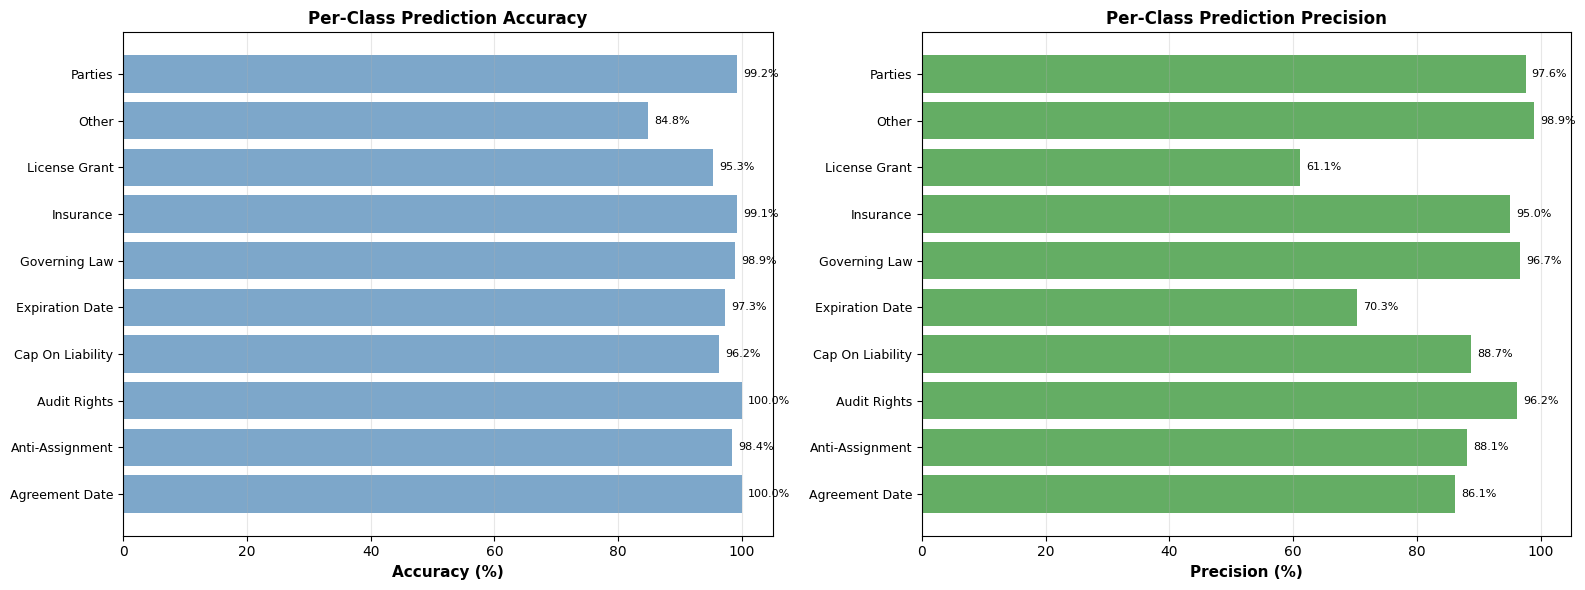


Confusion Matrix:
[[ 87   0   0   0   0   0   0   0   0   0]
 [  0 126   0   0   0   0   0   0   1   1]
 [  0   0 102   0   0   0   0   0   0   0]
 [  0   0   0 102   0   1   1   0   2   0]
 [  1   0   0   0  71   0   0   0   1   0]
 [  0   0   0   0   0  89   0   0   0   1]
 [  0   0   0   0   1   0 115   0   0   0]
 [  0   0   0   0   0   0   0 102   4   1]
 [ 13  16   4  13  29   2   4  65 846   6]
 [  0   1   0   0   0   0   1   0   1 362]]


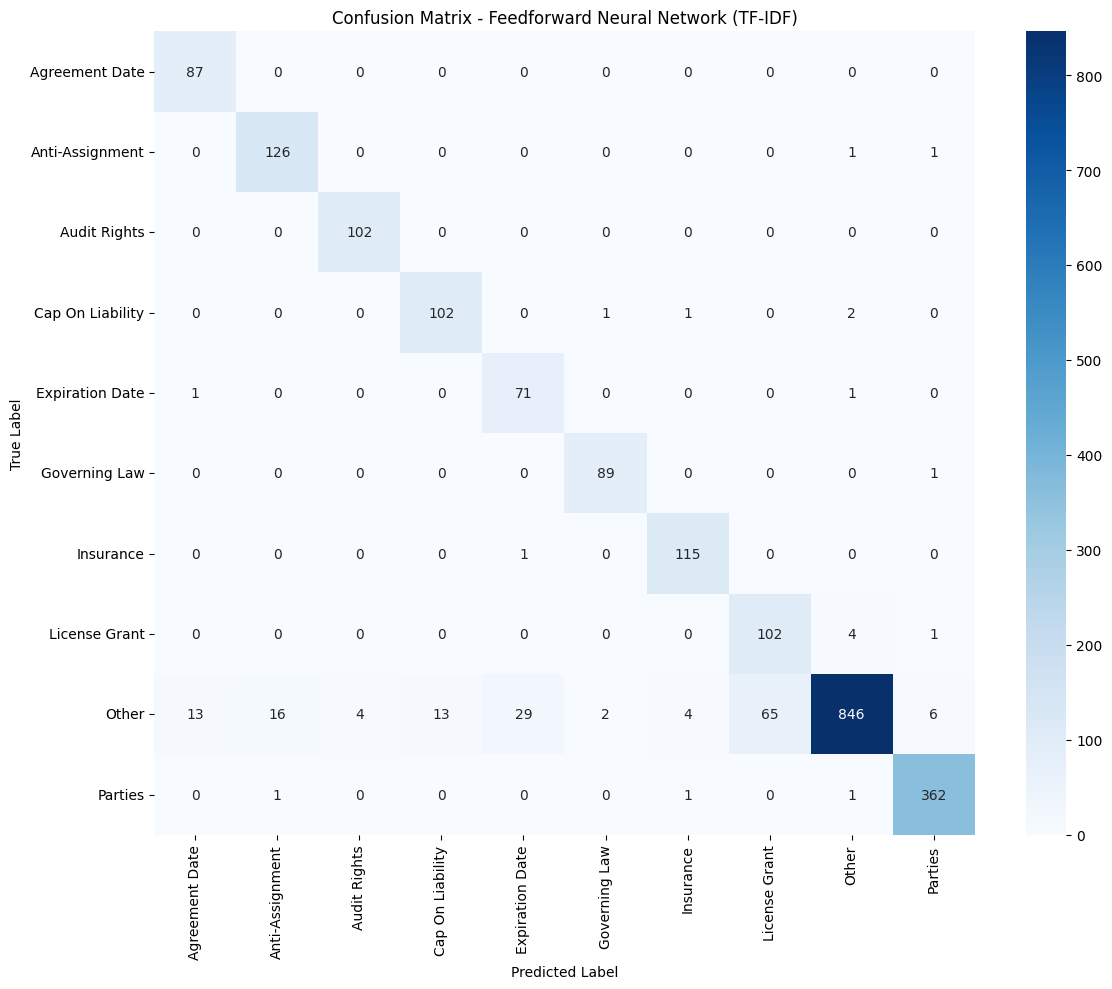

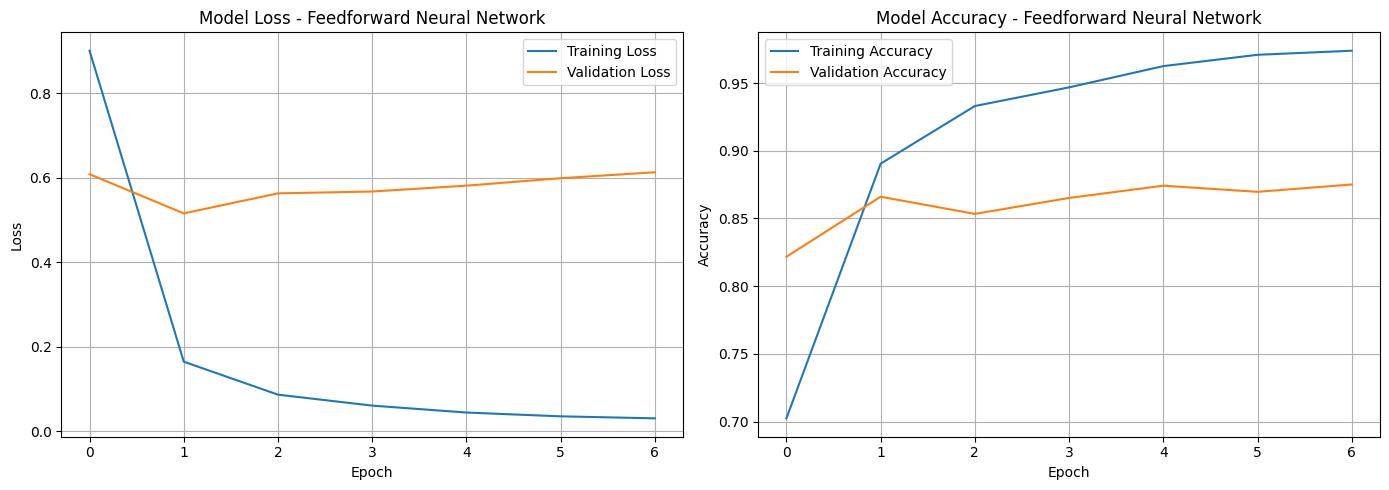

In [41]:
print("EVALUATING FEEDFORWARD NEURAL NETWORK")
y_pred_ff = model_ff.predict(X_test_tfidf_dense, verbose=0)
y_pred_ff_classes = np.argmax(y_pred_ff, axis=1)
test_loss_ff, test_accuracy_ff = model_ff.evaluate(X_test_tfidf_dense, y_test, verbose=0)

print(f"\nTest Set Performance:")
print(f"  Loss: {test_loss_ff:.4f}")
print(f"  Accuracy: {test_accuracy_ff:.4f} ({test_accuracy_ff*100:.2f}%)")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_ff_classes,
                          target_names=[reverse_label_mapping[i] for i in range(num_classes)]))

precision_ff = precision_score(y_test, y_pred_ff_classes, average='weighted', zero_division=0)
recall_ff = recall_score(y_test, y_pred_ff_classes, average='weighted', zero_division=0)
f1_ff = f1_score(y_test, y_pred_ff_classes, average='weighted', zero_division=0)
f1_macro_ff = f1_score(y_test, y_pred_ff_classes, average='macro', zero_division=0)

print(f"\nOverall Metrics:")
print(f"  Precision (weighted): {precision_ff:.4f}")
print(f"  Recall (weighted): {recall_ff:.4f}")
print(f"  F1-score (weighted): {f1_ff:.4f}")
print(f"  F1-score (macro): {f1_macro_ff:.4f}")

cm_ff = confusion_matrix(y_test, y_pred_ff_classes)
precision_per_class_ff = precision_score(y_test, y_pred_ff_classes, average=None, zero_division=0)
accuracy_per_class_ff = cm_ff.diagonal() / cm_ff.sum(axis=1)

print(f"\nPer-Class Prediction Accuracy and Precision")
print(f"\n{'Category':<45} {'Test Samples':<15} {'Correct':<12} {'Accuracy %':<15} {'Precision %':<15}")
print("-" * 102)
for i in range(num_classes):
    category_name = reverse_label_mapping[i][:43]
    true_count = int(cm_ff.sum(axis=1)[i])
    correct_count = int(cm_ff.diagonal()[i])
    accuracy_pct = accuracy_per_class_ff[i] * 100
    precision_pct = precision_per_class_ff[i] * 100
    print(f"{category_name:<45} {true_count:<15} {correct_count:<12} {accuracy_pct:<15.2f} {precision_pct:<15.2f}")

category_names = [reverse_label_mapping[i] for i in range(num_classes)]
accuracy_pct_ff = accuracy_per_class_ff * 100
precision_pct_ff = precision_per_class_ff * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
x_pos = np.arange(len(category_names))

axes[0].barh(x_pos, accuracy_pct_ff, color='steelblue', alpha=0.7)
axes[0].set_yticks(x_pos)
axes[0].set_yticklabels(category_names, fontsize=9)
axes[0].set_xlabel('Accuracy (%)', fontsize=11, fontweight='bold')
axes[0].set_title('Per-Class Prediction Accuracy', fontsize=12, fontweight='bold')
axes[0].set_xlim([0, 105])
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(accuracy_pct_ff):
    axes[0].text(v + 1, i, f'{v:.1f}%', va='center', fontsize=8)

axes[1].barh(x_pos, precision_pct_ff, color='forestgreen', alpha=0.7)
axes[1].set_yticks(x_pos)
axes[1].set_yticklabels(category_names, fontsize=9)
axes[1].set_xlabel('Precision (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Per-Class Prediction Precision', fontsize=12, fontweight='bold')
axes[1].set_xlim([0, 105])
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(precision_pct_ff):
    axes[1].text(v + 1, i, f'{v:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.savefig(project_root / "Visualizations" / "feedforward_per_class_accuracy_precision.png", bbox_inches='tight', dpi=150)
plt.show()

results_ff = {
    'model': 'Feedforward MLP (TF-IDF)',
    'test_accuracy': test_accuracy_ff,
    'test_loss': test_loss_ff,
    'precision': precision_ff,
    'recall': recall_ff,
    'f1_weighted': f1_ff,
    'f1_macro': f1_macro_ff
}

print(f"\nConfusion Matrix:")
print(cm_ff)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_ff, annot=True, fmt='d', cmap='Blues',
            xticklabels=[reverse_label_mapping[i][:20] for i in range(num_classes)],
            yticklabels=[reverse_label_mapping[i][:20] for i in range(num_classes)])
plt.title('Confusion Matrix - Feedforward Neural Network (TF-IDF)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(project_root / "Visualizations" / "feedforward_confusion_matrix.png", bbox_inches='tight', dpi=150)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_ff.history['loss'], label='Training Loss')
axes[0].plot(history_ff.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss - Feedforward Neural Network')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_ff.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_ff.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy - Feedforward Neural Network')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(project_root / "Visualizations" / "feedforward_training_history.png", bbox_inches='tight', dpi=150)
plt.show()


In [42]:
print("MODEL 2: LSTM-BASED TEXT CLASSIFIER")

embedding_dim = 128
lstm_units = 128
dropout_rate = 0.3
recurrent_dropout = 0.2

print(f"\nModel Architecture:")
print(f"  Input Layer: Sequences of length {max_sequence_length}")
print(f"  Embedding Layer: {actual_vocab_size:,} vocab size, {embedding_dim} dims (random embeddings)")
print(f"  LSTM Layer: {lstm_units} units")
print(f"  Dropout: {dropout_rate}, Recurrent Dropout: {recurrent_dropout}")
print(f"  Dense Layer: {num_classes} units, Softmax activation")

model_lstm = Sequential([
    Embedding(input_dim=actual_vocab_size,
              output_dim=embedding_dim,
              input_length=max_sequence_length,
              name='embedding'),
    LSTM(lstm_units,
         dropout=dropout_rate,
         recurrent_dropout=recurrent_dropout,
         name='lstm'),
    Dropout(dropout_rate, name='dropout'),
    Dense(num_classes, activation='softmax', name='output')
])

model_lstm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nModel compiled successfully!")
print(f"\nModel Summary:")
model_lstm.summary()


use_bilstm = False

if use_bilstm:
    print("\nUsing Bidirectional LSTM for better context understanding...")
    model_lstm = Sequential([
        Embedding(input_dim=actual_vocab_size,
                  output_dim=embedding_dim,
                  input_length=max_sequence_length,
                  name='embedding'),
        Bidirectional(LSTM(lstm_units,
                           dropout=dropout_rate,
                           recurrent_dropout=recurrent_dropout),
                      name='bilstm'),
        Dropout(dropout_rate, name='dropout'),
        Dense(num_classes, activation='softmax', name='output')
    ])
    model_lstm.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )


MODEL 2: LSTM-BASED TEXT CLASSIFIER

Model Architecture:
  Input Layer: Sequences of length 138
  Embedding Layer: 9,833 vocab size, 128 dims (random embeddings)
  LSTM Layer: 128 units
  Dropout: 0.3, Recurrent Dropout: 0.2
  Dense Layer: 10 units, Softmax activation

Model compiled successfully!

Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### 3.2.1 Train LSTM Model


In [43]:
print("TRAINING LSTM-BASED TEXT CLASSIFIER")

batch_size = 32
epochs = 50
validation_split = 0.1

early_stopping_lstm = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint_lstm = ModelCheckpoint(
    str(project_root / "Models" / "best_model_lstm.h5"),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

print(f"\nTraining Configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Max epochs: {epochs}")
print(f"  Validation split: {validation_split}")
print(f"  Early stopping: Patience = 5")
print(f"  Class weights: Using balanced weights")

print(f"\nStarting training...")
history_lstm = model_lstm.fit(
    X_train_padded, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    class_weight=class_weights,
    callbacks=[early_stopping_lstm, model_checkpoint_lstm],
    verbose=1
)

print(f"\nTraining completed!")
print(f"  Best epoch: {len(history_lstm.history['loss'])}")
print(f"  Best validation loss: {min(history_lstm.history['val_loss']):.4f}")
print(f"  Best validation accuracy: {max(history_lstm.history['val_accuracy']):.4f}")


TRAINING LSTM-BASED TEXT CLASSIFIER

Training Configuration:
  Batch size: 32
  Max epochs: 50
  Validation split: 0.1
  Early stopping: Patience = 5
  Class weights: Using balanced weights

Starting training...
Epoch 1/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.0808 - loss: 2.2928
Epoch 1: val_loss improved from None to 2.31241, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.1062 - loss: 2.3012 - val_accuracy: 0.1810 - val_loss: 2.3124
Epoch 2/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0876 - loss: 2.2719
Epoch 2: val_loss did not improve from 2.31241
311/311 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.0912 - loss: 2.2807 - val_accuracy: 0.0452 - val_loss: 2.3131
Epoch 3/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0750 - loss: 2.2813
Epoch 3: val_loss improved from 2.31241 to 2.10431, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.0940 - loss: 2.2835 - val_accuracy: 0.1647 - val_loss: 2.1043
Epoch 4/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1281 - loss: 2.1439
Epoch 4: val_loss did not improve from 2.10431
311/311 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.1170 - loss: 2.2132 - val_accuracy: 0.0452 - val_loss: 2.3527
Epoch 5/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0896 - loss: 2.2803
Epoch 5: val_loss improved from 2.10431 to 1.96876, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.1221 - loss: 2.2411 - val_accuracy: 0.2253 - val_loss: 1.9688
Epoch 6/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1823 - loss: 1.8701
Epoch 6: val_loss did not improve from 1.96876
311/311 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.1958 - loss: 1.7860 - val_accuracy: 0.2796 - val_loss: 1.9820
Epoch 7/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2327 - loss: 1.5918
Epoch 7: val_loss improved from 1.96876 to 1.69336, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.2400 - loss: 1.5262 - val_accuracy: 0.3077 - val_loss: 1.6934
Epoch 8/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2821 - loss: 1.4052
Epoch 8: val_loss did not improve from 1.69336
311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.2961 - loss: 1.3340 - val_accuracy: 0.3457 - val_loss: 1.7358
Epoch 9/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3317 - loss: 1.1718
Epoch 9: val_loss improved from 1.69336 to 1.54602, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.3341 - loss: 1.1301 - val_accuracy: 0.3765 - val_loss: 1.5460
Epoch 10/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3703 - loss: 1.0285
Epoch 10: val_loss improved from 1.54602 to 1.46074, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.3862 - loss: 0.9768 - val_accuracy: 0.4670 - val_loss: 1.4607
Epoch 11/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4674 - loss: 0.8852
Epoch 11: val_loss improved from 1.46074 to 1.13078, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.4972 - loss: 0.8287 - val_accuracy: 0.5973 - val_loss: 1.1308
Epoch 12/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5775 - loss: 0.7361
Epoch 12: val_loss improved from 1.13078 to 0.97535, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.6034 - loss: 0.7033 - val_accuracy: 0.7086 - val_loss: 0.9753
Epoch 13/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6968 - loss: 0.5643
Epoch 13: val_loss improved from 0.97535 to 0.81669, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.7223 - loss: 0.5100 - val_accuracy: 0.7475 - val_loss: 0.8167
Epoch 14/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7502 - loss: 0.4618
Epoch 14: val_loss did not improve from 0.81669
311/311 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.7639 - loss: 0.4385 - val_accuracy: 0.7104 - val_loss: 0.8885
Epoch 15/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7894 - loss: 0.3813
Epoch 15: val_loss improved from 0.81669 to 0.80626, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.7989 - loss: 0.3813 - val_accuracy: 0.7674 - val_loss: 0.8063
Epoch 16/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7976 - loss: 0.3494
Epoch 16: val_loss did not improve from 0.80626
311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8039 - loss: 0.3477 - val_accuracy: 0.7394 - val_loss: 0.8561
Epoch 17/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8304 - loss: 0.3176
Epoch 17: val_loss did not improve from 0.80626
311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8358 - loss: 0.3171 - val_accuracy: 0.7575 - val_loss: 0.8509
Epoch 18/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8316 - loss: 0.3155
Epoch 18: val_loss improved from 0.80626 to 0.77061, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8399 - loss: 0.3163 - val_accuracy: 0.7900 - val_loss: 0.7706
Epoch 19/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8646 - loss: 0.2948
Epoch 19: val_loss did not improve from 0.77061
311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8725 - loss: 0.2707 - val_accuracy: 0.7837 - val_loss: 0.8731
Epoch 20/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8927 - loss: 0.1774
Epoch 20: val_loss did not improve from 0.77061
311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8992 - loss: 0.1712 - val_accuracy: 0.8045 - val_loss: 0.7872
Epoch 21/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9015 - loss: 0.1575
Epoch 21: val_loss did not improve from 0.77061
311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9036 - loss: 0.1543 - val_accuracy: 0.7928 - val_loss: 0.7983
Epoch 22/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9120 - loss: 0.1228
Epoch 22: val_loss did not i

311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9188 - loss: 0.1198 - val_accuracy: 0.8208 - val_loss: 0.7540
Epoch 24/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9166 - loss: 0.1121
Epoch 24: val_loss did not improve from 0.75403
311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9189 - loss: 0.1136 - val_accuracy: 0.8308 - val_loss: 0.7830
Epoch 25/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9281 - loss: 0.1019
Epoch 25: val_loss improved from 0.75403 to 0.75130, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9288 - loss: 0.1001 - val_accuracy: 0.8290 - val_loss: 0.7513
Epoch 26/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9260 - loss: 0.1055
Epoch 26: val_loss did not improve from 0.75130
311/311 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9263 - loss: 0.1085 - val_accuracy: 0.8027 - val_loss: 0.8390
Epoch 27/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9246 - loss: 0.0972
Epoch 27: val_loss did not improve from 0.75130
311/311 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9308 - loss: 0.0945 - val_accuracy: 0.8380 - val_loss: 0.7976
Epoch 28/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9379 - loss: 0.0815
Epoch 28: val_loss did not improve from 0.75130
311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9356 - loss: 0.0855 - val_accuracy: 0.8335 - val_loss: 0.8120
Epoch 29/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9340 - loss: 0.0913
Epoch 29: val_loss did not i

#### 3.2.2 Evaluate LSTM Model

We evaluate the LSTM model's performance using the same metrics as the Feedforward model. This allows us to compare both models and determine which performs better for each legal clause category.


EVALUATING LSTM-BASED TEXT CLASSIFIER

Test Set Performance:
  Loss: 0.3219
  Accuracy: 0.9199 (91.99%)

Classification Report:
                  precision    recall  f1-score   support

  Agreement Date       0.90      1.00      0.95        87
 Anti-Assignment       0.87      0.98      0.92       128
    Audit Rights       0.90      0.98      0.94       102
Cap On Liability       0.87      0.97      0.92       106
 Expiration Date       0.70      0.99      0.82        73
   Governing Law       0.99      1.00      0.99        90
       Insurance       0.91      0.98      0.95       116
   License Grant       0.65      0.98      0.78       107
           Other       0.98      0.85      0.91       998
         Parties       0.99      0.97      0.98       365

        accuracy                           0.92      2172
       macro avg       0.88      0.97      0.92      2172
    weighted avg       0.93      0.92      0.92      2172


Overall Metrics:
  Precision (weighted): 0.9344
  Recall

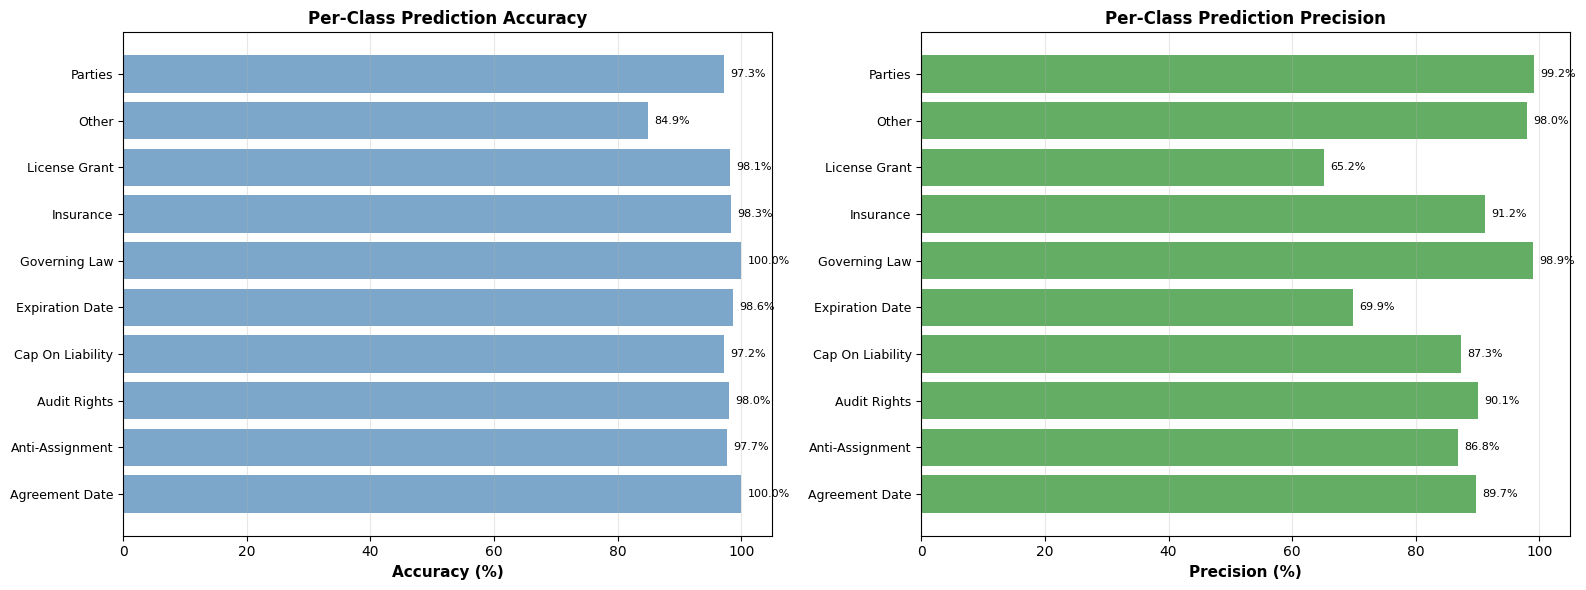


Confusion Matrix:
[[ 87   0   0   0   0   0   0   0   0   0]
 [  0 125   0   0   0   0   0   0   3   0]
 [  0   0 100   0   0   0   0   0   2   0]
 [  0   0   0 103   0   0   0   0   3   0]
 [  0   0   0   0  72   0   0   0   1   0]
 [  0   0   0   0   0  90   0   0   0   0]
 [  0   0   0   0   0   0 114   0   1   1]
 [  0   0   0   0   0   0   0 105   1   1]
 [  9  19  10  15  30   1  10  56 847   1]
 [  1   0   1   0   1   0   1   0   6 355]]


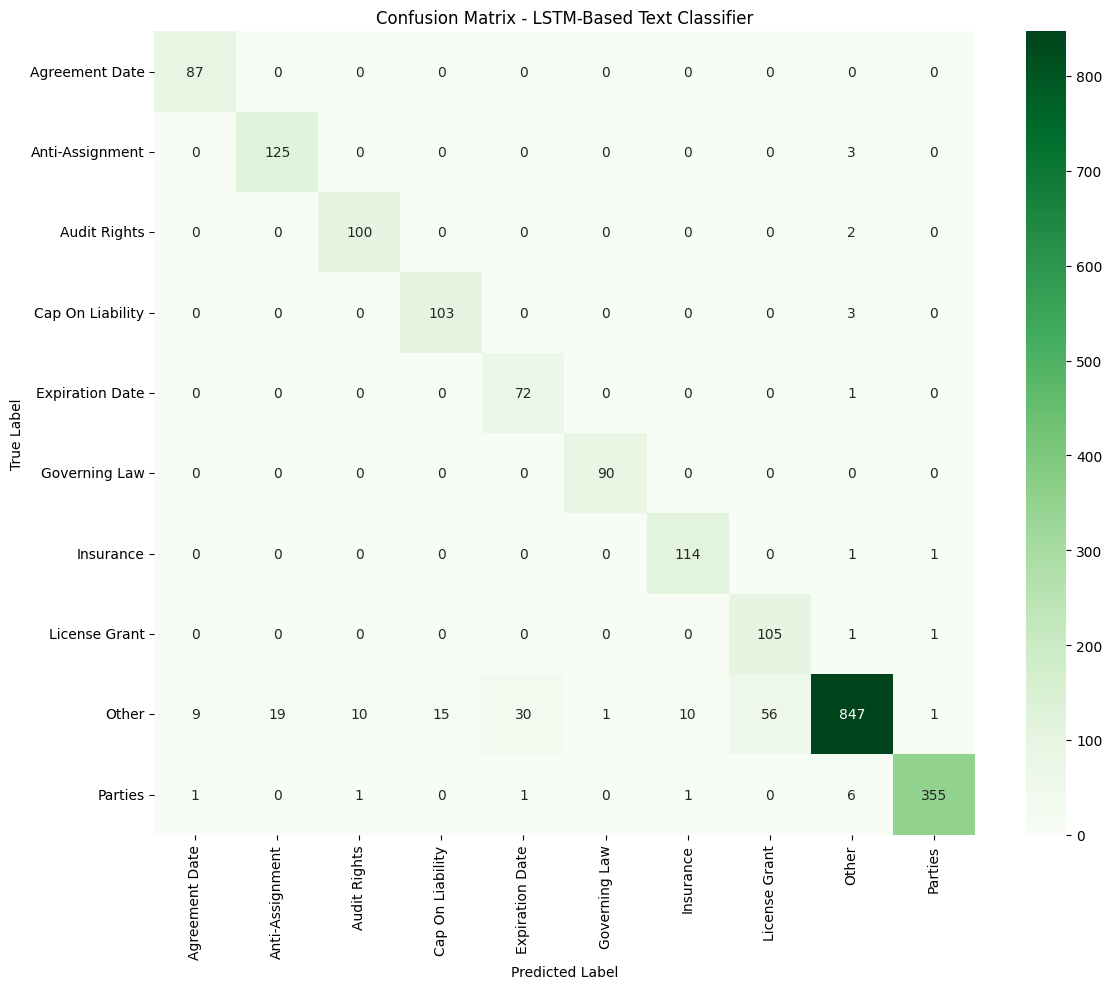

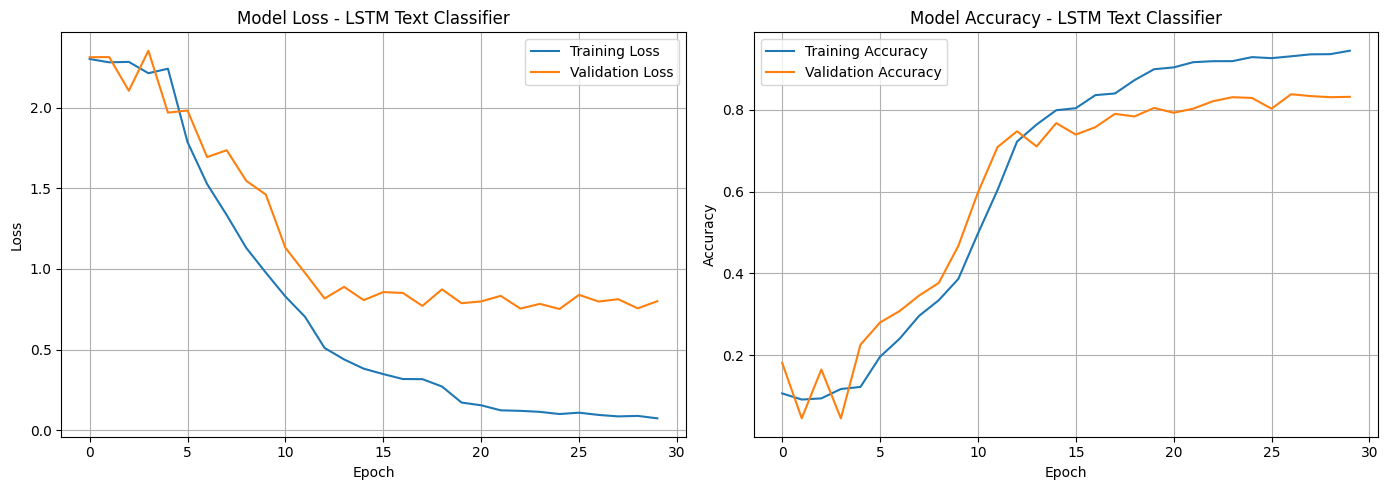

In [44]:
print("EVALUATING LSTM-BASED TEXT CLASSIFIER")

y_pred_lstm = model_lstm.predict(X_test_padded, verbose=0)
y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)
test_loss_lstm, test_accuracy_lstm = model_lstm.evaluate(X_test_padded, y_test, verbose=0)

print(f"\nTest Set Performance:")
print(f"  Loss: {test_loss_lstm:.4f}")
print(f"  Accuracy: {test_accuracy_lstm:.4f} ({test_accuracy_lstm*100:.2f}%)")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lstm_classes,
                          target_names=[reverse_label_mapping[i] for i in range(num_classes)]))

precision_lstm = precision_score(y_test, y_pred_lstm_classes, average='weighted', zero_division=0)
recall_lstm = recall_score(y_test, y_pred_lstm_classes, average='weighted', zero_division=0)
f1_lstm = f1_score(y_test, y_pred_lstm_classes, average='weighted', zero_division=0)
f1_macro_lstm = f1_score(y_test, y_pred_lstm_classes, average='macro', zero_division=0)

print(f"\nOverall Metrics:")
print(f"  Precision (weighted): {precision_lstm:.4f}")
print(f"  Recall (weighted): {recall_lstm:.4f}")
print(f"  F1-score (weighted): {f1_lstm:.4f}")
print(f"  F1-score (macro): {f1_macro_lstm:.4f}")

cm_lstm = confusion_matrix(y_test, y_pred_lstm_classes)
precision_per_class_lstm = precision_score(y_test, y_pred_lstm_classes, average=None, zero_division=0)
accuracy_per_class_lstm = cm_lstm.diagonal() / cm_lstm.sum(axis=1)

print(f"\nPer-Class Prediction Accuracy and Precision")
print(f"\n{'Category':<45} {'Test Samples':<15} {'Correct':<12} {'Accuracy %':<15} {'Precision %':<15}")
print("-" * 102)
for i in range(num_classes):
    category_name = reverse_label_mapping[i][:43]
    true_count = int(cm_lstm.sum(axis=1)[i])
    correct_count = int(cm_lstm.diagonal()[i])
    accuracy_pct = accuracy_per_class_lstm[i] * 100
    precision_pct = precision_per_class_lstm[i] * 100
    print(f"{category_name:<45} {true_count:<15} {correct_count:<12} {accuracy_pct:<15.2f} {precision_pct:<15.2f}")

category_names = [reverse_label_mapping[i] for i in range(num_classes)]
accuracy_pct_lstm = accuracy_per_class_lstm * 100
precision_pct_lstm = precision_per_class_lstm * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
x_pos = np.arange(len(category_names))

axes[0].barh(x_pos, accuracy_pct_lstm, color='steelblue', alpha=0.7)
axes[0].set_yticks(x_pos)
axes[0].set_yticklabels(category_names, fontsize=9)
axes[0].set_xlabel('Accuracy (%)', fontsize=11, fontweight='bold')
axes[0].set_title('Per-Class Prediction Accuracy', fontsize=12, fontweight='bold')
axes[0].set_xlim([0, 105])
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(accuracy_pct_lstm):
    axes[0].text(v + 1, i, f'{v:.1f}%', va='center', fontsize=8)

axes[1].barh(x_pos, precision_pct_lstm, color='forestgreen', alpha=0.7)
axes[1].set_yticks(x_pos)
axes[1].set_yticklabels(category_names, fontsize=9)
axes[1].set_xlabel('Precision (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Per-Class Prediction Precision', fontsize=12, fontweight='bold')
axes[1].set_xlim([0, 105])
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(precision_pct_lstm):
    axes[1].text(v + 1, i, f'{v:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.savefig(project_root / "Visualizations" / "lstm_per_class_accuracy_precision.png", bbox_inches='tight', dpi=150)
plt.show()

results_lstm = {
    'model': 'LSTM Text Classifier',
    'test_accuracy': test_accuracy_lstm,
    'test_loss': test_loss_lstm,
    'precision': precision_lstm,
    'recall': recall_lstm,
    'f1_weighted': f1_lstm,
    'f1_macro': f1_macro_lstm
}

print(f"\nConfusion Matrix:")
print(cm_lstm)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens',
            xticklabels=[reverse_label_mapping[i][:20] for i in range(num_classes)],
            yticklabels=[reverse_label_mapping[i][:20] for i in range(num_classes)])
plt.title('Confusion Matrix - LSTM-Based Text Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(project_root / "Visualizations" / "lstm_confusion_matrix.png", bbox_inches='tight', dpi=150)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_lstm.history['loss'], label='Training Loss')
axes[0].plot(history_lstm.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss - LSTM Text Classifier')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_lstm.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy - LSTM Text Classifier')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(project_root / "Visualizations" / "lstm_training_history.png", bbox_inches='tight', dpi=150)
plt.show()


### 3.3 Model Comparison


MODEL COMPARISON

Performance Comparison:
                   model  test_accuracy  test_loss  precision   recall  f1_weighted  f1_macro
Feedforward MLP (TF-IDF)       0.921731   0.267939   0.938083 0.921731     0.924311  0.916518
    LSTM Text Classifier       0.919890   0.321947   0.934383 0.919890     0.921908  0.915747


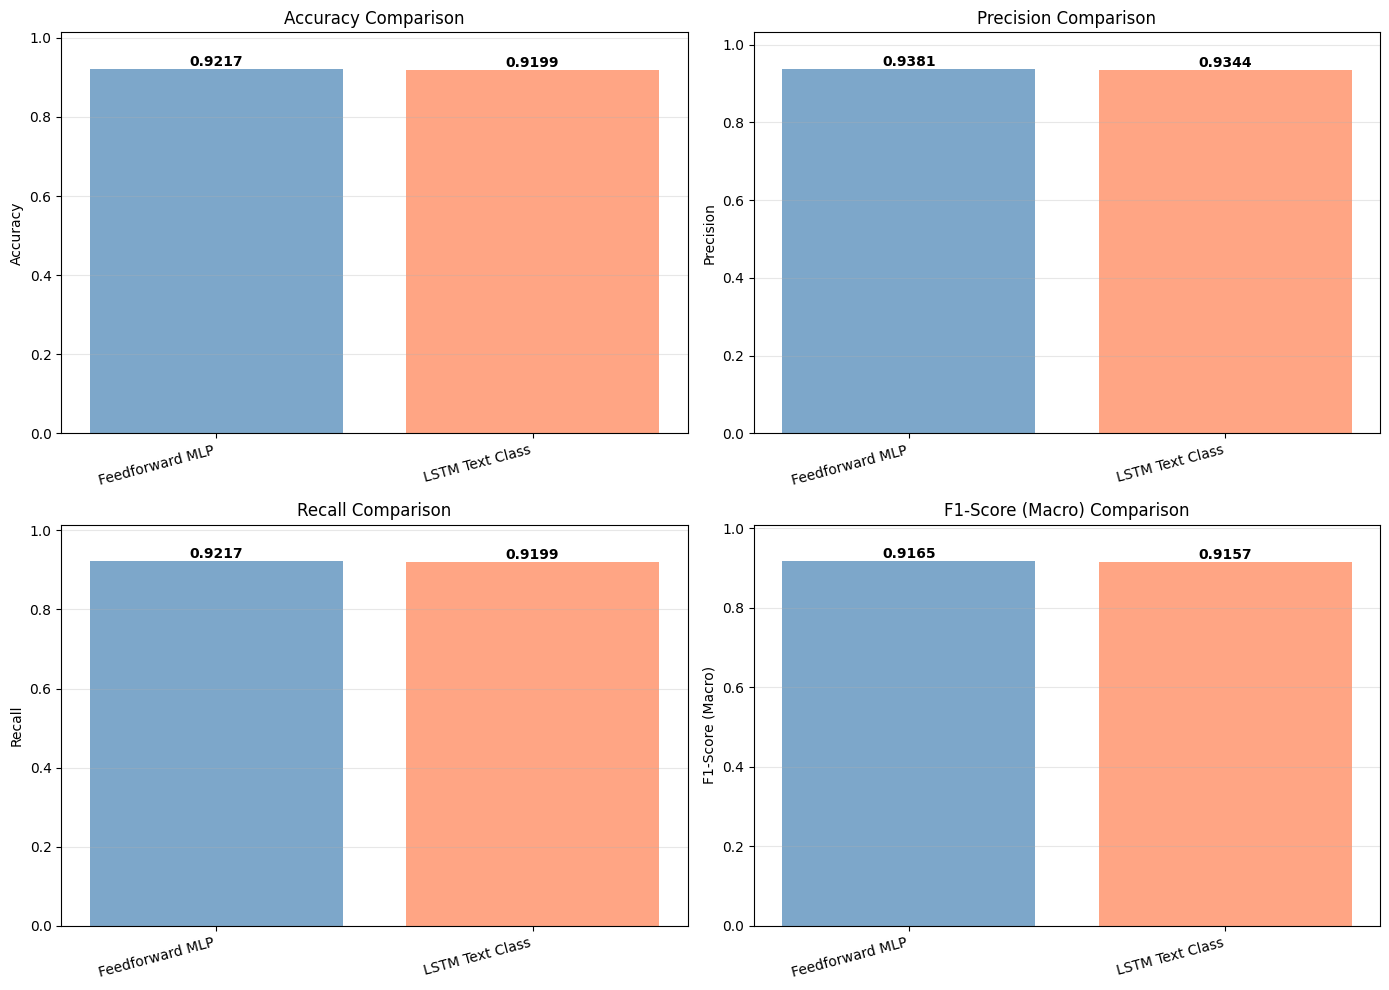


DETAILED COMPARISON TABLE

              Metric Feedforward MLP (TF-IDF) LSTM Text Classifier
       Test Accuracy                   0.9217               0.9199
           Test Loss                   0.2679               0.3219
Precision (Weighted)                   0.9381               0.9344
   Recall (Weighted)                   0.9217               0.9199
 F1-Score (Weighted)                   0.9243               0.9219
    F1-Score (Macro)                   0.9165               0.9157

Best Model (by Macro F1-Score): Feedforward MLP (TF-IDF)
  Improvement: 0.08%


In [45]:
print("MODEL COMPARISON")

comparison_df = pd.DataFrame([results_ff, results_lstm])

print("\nPerformance Comparison:")
print(comparison_df.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_compare = ['test_accuracy', 'precision', 'recall', 'f1_macro']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score (Macro)']

for idx, (metric, label) in enumerate(zip(metrics_to_compare, metric_labels)):
    ax = axes[idx // 2, idx % 2]
    models = comparison_df['model'].values
    values = comparison_df[metric].values

    bars = ax.bar(models, values, color=['steelblue', 'coral'], alpha=0.7)
    ax.set_ylabel(label)
    ax.set_title(f'{label} Comparison')
    ax.set_ylim(0, max(values) * 1.1)
    ax.grid(axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold')

    ax.set_xticklabels([m[:15] for m in models], rotation=15, ha='right')

plt.tight_layout()
plt.savefig(project_root / "Visualizations" / "model_comparison.png", bbox_inches='tight', dpi=150)
plt.show()


print("\nDETAILED COMPARISON TABLE")

comparison_table = pd.DataFrame({
    'Metric': ['Test Accuracy', 'Test Loss', 'Precision (Weighted)',
               'Recall (Weighted)', 'F1-Score (Weighted)', 'F1-Score (Macro)'],
    'Feedforward MLP (TF-IDF)': [
        f"{results_ff['test_accuracy']:.4f}",
        f"{results_ff['test_loss']:.4f}",
        f"{results_ff['precision']:.4f}",
        f"{results_ff['recall']:.4f}",
        f"{results_ff['f1_weighted']:.4f}",
        f"{results_ff['f1_macro']:.4f}"
    ],
    'LSTM Text Classifier': [
        f"{results_lstm['test_accuracy']:.4f}",
        f"{results_lstm['test_loss']:.4f}",
        f"{results_lstm['precision']:.4f}",
        f"{results_lstm['recall']:.4f}",
        f"{results_lstm['f1_weighted']:.4f}",
        f"{results_lstm['f1_macro']:.4f}"
    ]
})

print("\n" + comparison_table.to_string(index=False))

if results_ff['f1_macro'] > results_lstm['f1_macro']:
    winner = "Feedforward MLP (TF-IDF)"
    improvement = ((results_ff['f1_macro'] - results_lstm['f1_macro']) / results_lstm['f1_macro']) * 100
else:
    winner = "LSTM Text Classifier"
    improvement = ((results_lstm['f1_macro'] - results_ff['f1_macro']) / results_ff['f1_macro']) * 100

print(f"\nBest Model (by Macro F1-Score): {winner}")
print(f"  Improvement: {improvement:.2f}%")


### 3.3.1 Future work

Add per-class plots; explore embeddings.
